# Evaluate hydrological projections from several climate projections (with different climate models and scenarios) using a monthly delta change approach

## Introduction

Nokebook for the workflow **Snakefile_future_hydrology_delta_change**: runs a hydrological model for future climate projections based on the delta change approach. The delta change approach transforms historical meteorological data to represent  future conditions based on monthly gridded change factors. These gridded change factors are derived from the future and historical climate model (GCM or RCM) in the previous workflow **Snakefile_climate_projections**. The selection of the most suitable historical meteorological dataset can be based on the evaluations done in **Snakefile_climate_historical** and **Snakefile_historical_hydrology**. 

In the current workflow, the hydrological model is run for a selection of future climates and plots are made to evaluate the impact of climate change on the hydrology of the basin (future streamflow, snow, evaporation, glacier storage, groundwater recharge and other internal state and flux variables). 

NB: **Snakefile_future_hydrology_delta_change** requires to have run **Snakefile_climate_projections** and to have run a historical hydrology run which is used as reference for the delta change approach (**Snakefile_historical_hydrology**). 

In [2]:
# Import some python libraries we will need to run this notebook
import os
from IPython import display

In [3]:
# A helper function
from subprocess import Popen, PIPE, STDOUT

from IPython.core.magic import register_line_magic


@register_line_magic
def runrealcmd(command):
    with Popen(
        command, stdout=PIPE, shell=True, stderr=STDOUT, bufsize=1, close_fds=True
    ) as process:
        for line in iter(process.stdout.readline, b""):
            print(line.rstrip().decode("utf-8"))

## Choosing your climate datasets and scenarios

First thing is to prepare all the options for your project, this is done using the configuration or settings file below

In [4]:
# Add here the path where you have installed the blueearth-cst tool
cst_path = r'c:\repos\blueearth_cst'
os.chdir(cst_path)

In this workflow, the basin has already been selected. Nonetheless, the configuration file below recaps the general settings that were applied in the previous workflows to select the region. 

In [27]:
%%writefile ./config/my-project-settings.yml

########################################################################################
#################################### General settings ##################################

# Path to where the wflow model will be stored (include the project name)
project_dir: examples/myModel

# Path to the data catalog to use (can be different for Linux/Windows/data stored on P drive or other)
# NB: should be in order of priority! 
data_sources: 
  - artifact_data
  - tests/data/tests_data_catalog.yml

########################################################################################
######################### Analysis of future hydrology delta change ####################
# (Calibrated) reference historical wflow runs - path to the toml file relative to hydrology_model folder
config_model_historical: "run_default/wflow_sbm_era5.toml"

# climate models and scenarios
clim_project: cmip6
historical: 2000, 2010
#assume period is near and far (fixed!!)
future_horizons: 
  near: 2050, 2060
  far: 2090, 2100
gcm_selected: ['NOAA-GFDL_GFDL-ESM4', 'INM_INM-CM5-0']
scenarios_selected: [ssp245, ssp585]

# List of wflow output variables to save
# Supported variables: ['river discharge', 'precipitation', 'overland flow', 'actual evaporation', 'groundwater recharge', 'snow', 'glacier']
# Comment out to disable saving
# Scalar csv
wflow_outvars: ['river discharge', 'precipitation', 'overland flow', 'actual evaporation', 'groundwater recharge', 'snow']
# Gridded netcdf
wflow_outvars_gridded: ['snow']

future_hydrology_plots:
  add_plots_with_all_lines: true

Overwriting ./config/my-project-settings.yml


## Running the model building workflow

The first line is to create an image of the different rules within our workflow with snakemake to verify that all our settings are well taken into account.

In [14]:
! snakemake -s snakemake/Snakefile_future_hydrology_delta_change.smk --configfile config/my-project-settings.yml  --dag | dot -Tpng > dag_hydrological_projections.png


Building DAG of jobs...


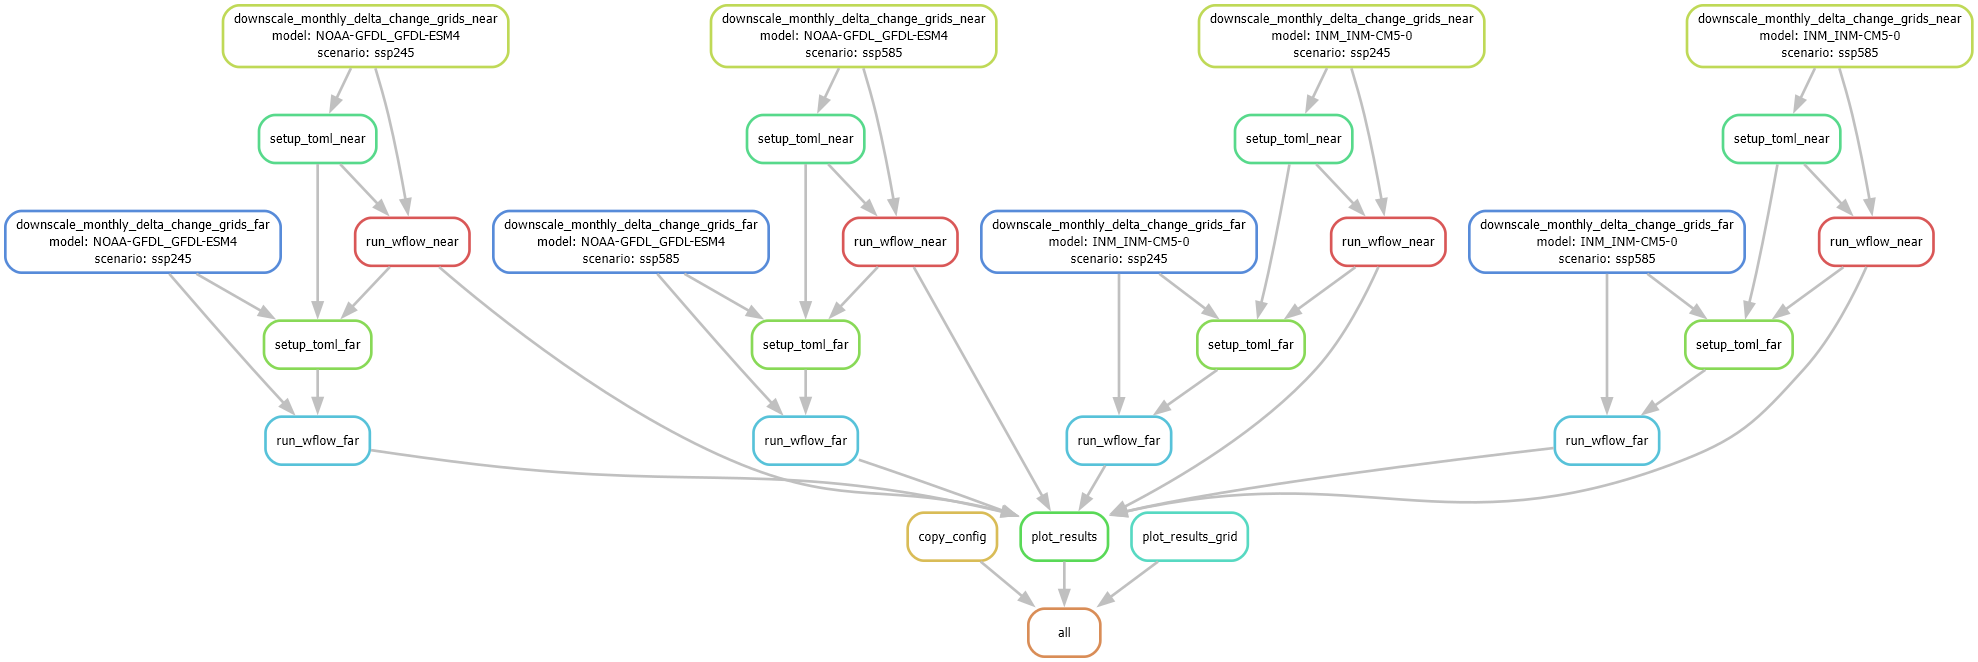

In [15]:
display.Image("./dag_hydrological_projections.png")

Let's have a closer look at the different rules within this workflow:

1. `downscale_monthly_delta_change_grids_near`: this rule downscales the monthly gridded change factors for the near future derived in the previous workflow (**Snakefile_climate_projections**) to the model resolution. This is done for a selection of climate models and scenarios, as provided in the configuration file under *gcm_selected* and *scenarios_selected*.    
2. `setup_toml_near`: in this rule, the configuration file of the wflow model, the so-called toml file, is set-up to run the delta change future period. The user needs to provide the path to the historical hydrology toml file under *config_model_historical* of the config file. This toml file of the historical hydrology run refers to a selected historical meteorological dataset. This dataset is modified with the delta change factors to represent the future projected conditions of a specific climate model and climate scenario. To run the wflow model over the near future, the model uses the final states of the historical hydrology run as initial states. This is especially relevant in basins with glaciers to meaningfully keep track of them.    
3. `run_wflow_near`: this rule uses the previously set-up toml file to run the wflow model for the near future period of a specific climate model and scenario. The historical meteorological dataset is transformed according to the change factors to represent the future period. Note that an alternative run function of the wflow julia model is called to run the model, which calculates the changed meteorological input on-the-fly based on the historical meteo netcdf and the gridded change factors netcdf files. 
4. `downscale_monthly_delta_change_grids_far`: this rule downscales the monthly gridded change factors for the far future derived in the previous workflow (**Snakefile_climate_projections**) to the model resolution. This is done in a similar way as was done for the near future. 
5. `setup_toml_far`: similarly to step 2, the toml file for the far future runs are now set-up. The rules are splitted in such a way between the near and the far future to be able to use the final states of the near future run as initial states for the far future run. This is again important to meaningfully account for changes in glacier storage, but potentially also groundwater storage. 
6. `run_wflow_far`: this rule runs the wflow model for the far future, in a similar way as explained under step 3. 
7. `plot_results`: this rule plots several figures to evaluate the impact of climate change on the hydrology of a basin. These figures show absolute values and relative monthly and annual change of several flux and state variables, including streamflow, actual evaporation, snow storage, glacier storage, groundwater recharge and overland flow. The uncertainty across climate models is either shown by plotting the mean change and shaded min-max areas or by showing each line for each climate model (option *future_hydrology_plots.add_plots_with_all_lines: true* in the config file).
8. `plot_results_grid`: in addition of showing mean areal annual and monthly change, the workflow allows to plot gridded change in mean annual snow storage for each climate model (if *snow* is provided as variables in *wflow_outvars_gridded* of the config file).  
9. `copy_config`: all configuration files are saved to make the workflow reproducible. 

Now we will unlock your directory in order to save the future results of the workflow. This step is most of the time not necessary.

In [16]:
! snakemake --unlock -s snakemake/Snakefile_future_hydrology_delta_change.smk --configfile config/my-project-settings.yml

Building DAG of jobs...
Unlocked working directory.


Snakemake also allows us to run a so-called *dryrun*, which will not actually run the workflow, but just print an overview of the rules that will be executed.

In [25]:
! snakemake all -c 1 -s snakemake/Snakefile_future_hydrology_delta_change.smk --configfile config/my-project-settings.yml --dryrun

And finally let's run our worflow:

In [24]:
%runrealcmd snakemake all -c 1 -s snakemake/Snakefile_future_hydrology_delta_change.smk --configfile config/my-project-settings.yml

## Results

First check that snake did run everything.

In [24]:
! snakemake -s snakemake/Snakefile_future_hydrology_delta_change.smk --configfile config/my-project-settings.yml  --dag | dot -Tpng > dag_hydrological_projections.png

Building DAG of jobs...


The diagram figure with all the rules will show dotted lines when a rule has successfully been executed. 

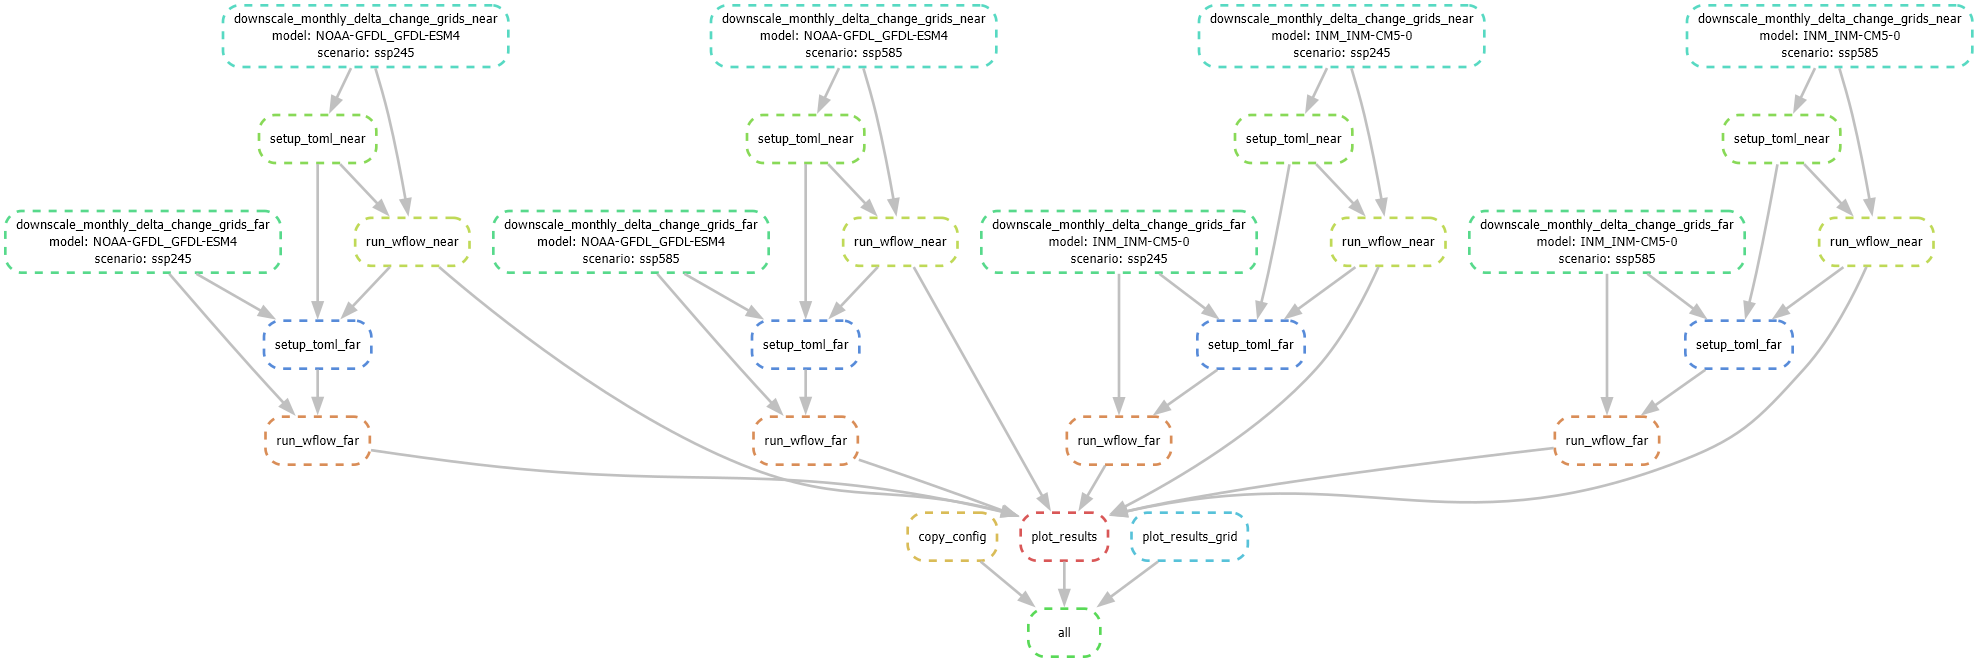

In [25]:
display.Image("./dag_hydrological_projections.png")

Let's see which files where created in our output folder.

A new directory has been created which contains all the wflow model files for the delta change runs. The scalar and netcdf output are available for each climate model, scenario and future horizon. Also each of the wflow configuration file (toml files) are available as shown below.

In [5]:
root = "examples/myModel/hydrology_model/run_delta_change"
for path, _, files in os.walk(root):
    print(path)
    for name in files:
        if name.endswith(".xml"):
            continue
        print(f" - {name}")

examples/myModel/hydrology_model/run_delta_change
 - hydromt.log
 - output_delta_INM_INM-CM5-0_ssp245_far.csv
 - output_delta_INM_INM-CM5-0_ssp245_far.nc
 - output_delta_INM_INM-CM5-0_ssp245_near.csv
 - output_delta_INM_INM-CM5-0_ssp245_near.nc
 - output_delta_INM_INM-CM5-0_ssp585_far.csv
 - output_delta_INM_INM-CM5-0_ssp585_far.nc
 - output_delta_INM_INM-CM5-0_ssp585_near.csv
 - output_delta_INM_INM-CM5-0_ssp585_near.nc
 - output_delta_NOAA-GFDL_GFDL-ESM4_ssp245_far.csv
 - output_delta_NOAA-GFDL_GFDL-ESM4_ssp245_far.nc
 - output_delta_NOAA-GFDL_GFDL-ESM4_ssp245_near.csv
 - output_delta_NOAA-GFDL_GFDL-ESM4_ssp245_near.nc
 - output_delta_NOAA-GFDL_GFDL-ESM4_ssp585_far.csv
 - output_delta_NOAA-GFDL_GFDL-ESM4_ssp585_far.nc
 - output_delta_NOAA-GFDL_GFDL-ESM4_ssp585_near.csv
 - output_delta_NOAA-GFDL_GFDL-ESM4_ssp585_near.nc
 - wflow_sbm_era5_delta_INM_INM-CM5-0_ssp245_far.toml
 - wflow_sbm_era5_delta_INM_INM-CM5-0_ssp245_near.toml
 - wflow_sbm_era5_delta_INM_INM-CM5-0_ssp585_far.toml
 - w

In addition, also a new directory is created which contains all the figures and output from the workflow. The plots are organized in two directories, one with all the streamflow results for each gauging station and one folder for all other flux and state variables, as shown below.

In [8]:
root = "examples/myModel/plots/model_delta_runs"
for path, _, files in os.walk(root):
    print(path)

examples/myModel/plots/model_delta_runs
examples/myModel/plots/model_delta_runs\flow
examples/myModel/plots/model_delta_runs\flow\1
examples/myModel/plots/model_delta_runs\other


Now let's have a closer look at the plots which were actually created. We start with the streamflow related figures. In the figure below, we show the projected change in mean monthly streamflow for the near future horizon (2050-2060) and the far future horizon (2090-2100). The line show the mutli-model mean across the different climate models for a specific scenario. The shaded area represent the min-max range across climate models. Instead of showing shaded area, the workflow also has the option (*future_hydrology_plots.add_plots_with_all_lines: true*) to show each line representing a single climate model. 

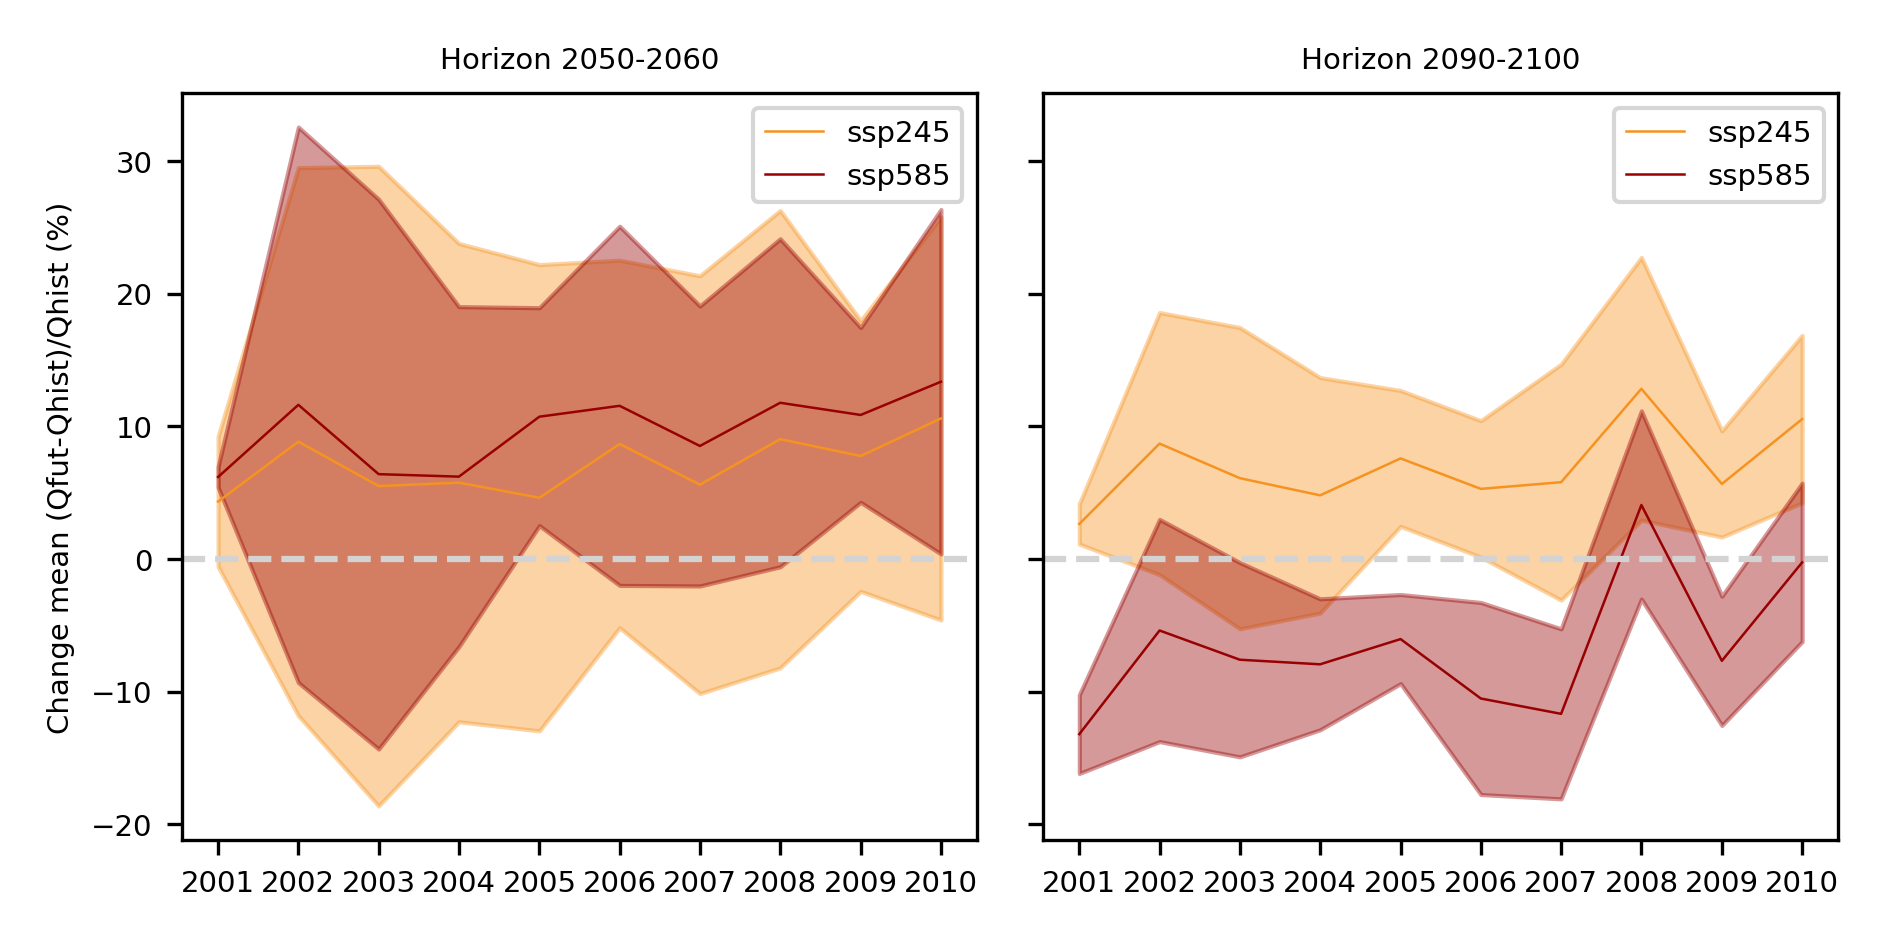

In [10]:
display.Image("./examples/myModel/plots/model_delta_runs/flow/1/rel_mean_annual_q_1.png")

Below we see the same figure, but then with each line for each climate model instead of the shaded area. These additional figures may be useful for the expert user who wants to gain more insight in the variability across climate models. In this very simple example, we only run the model for 2 climate models.

These figures are also available with the absolute values instead of the relative change compared to the historical conditions.

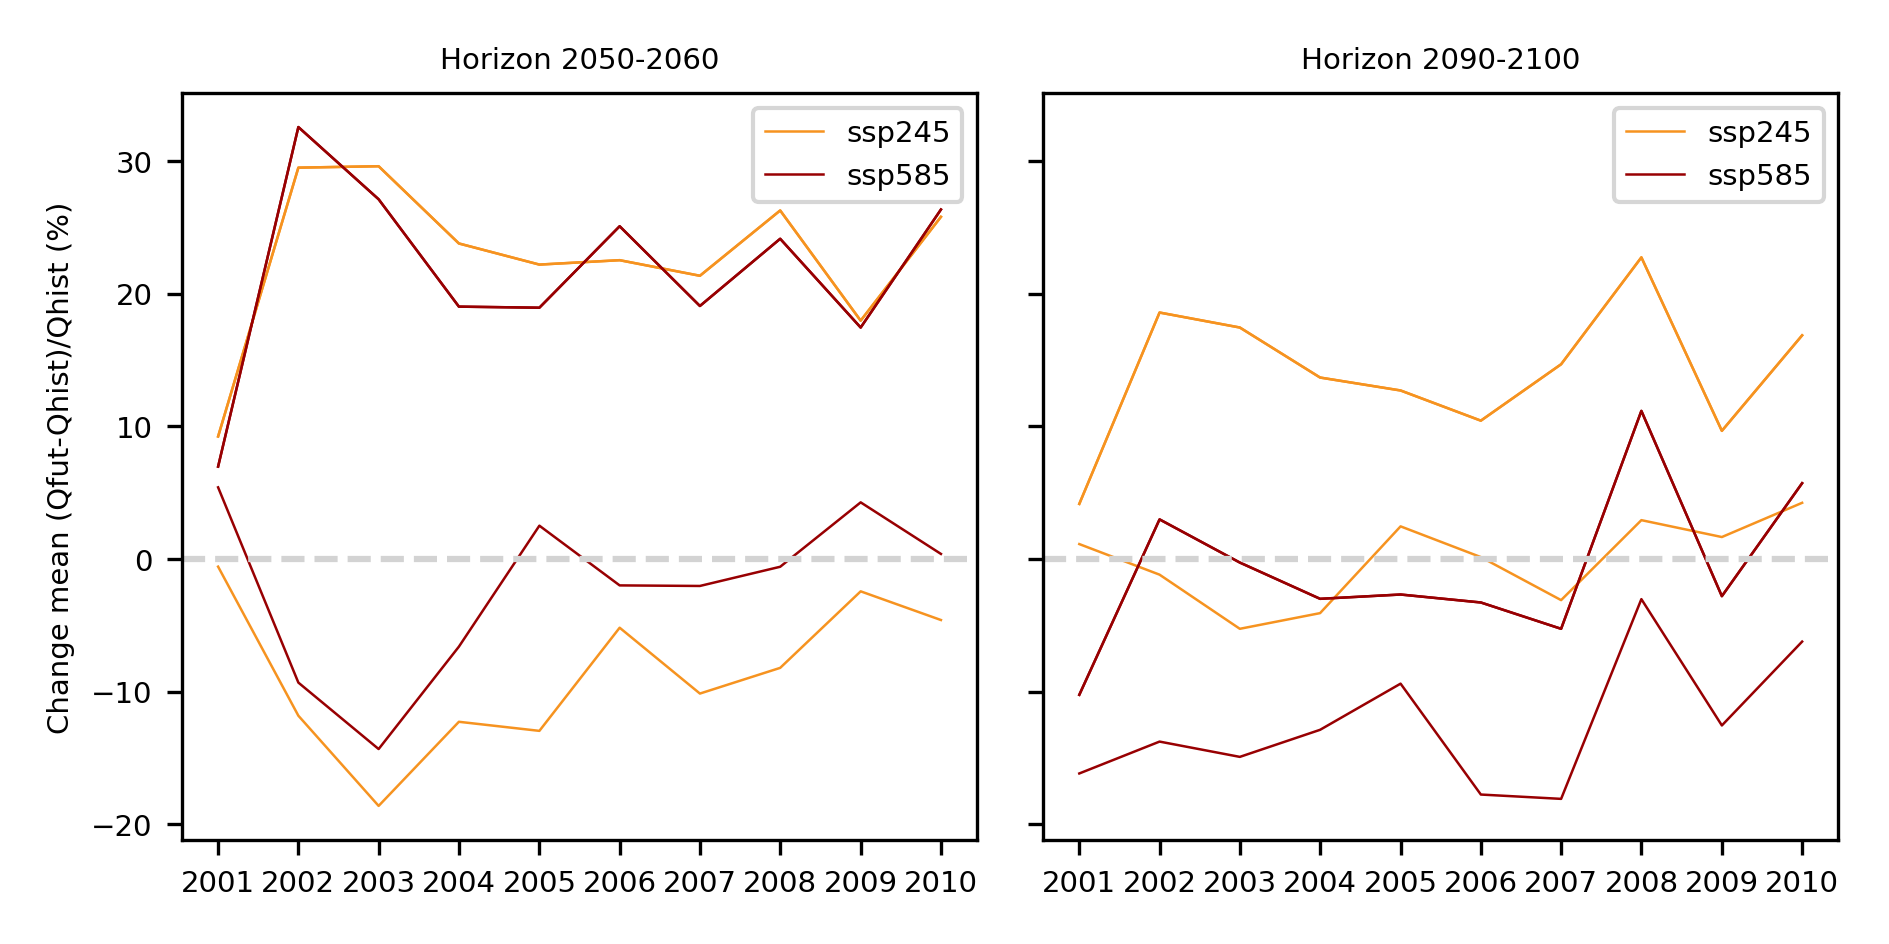

In [11]:
display.Image("./examples/myModel/plots/model_delta_runs/flow/1/rel_mean_annual_q_1_all_lines.png")

In addition to mean monthly change, the workflow also evaluates the change in minimum and maximum annual streamflow as shown in the figures below. 

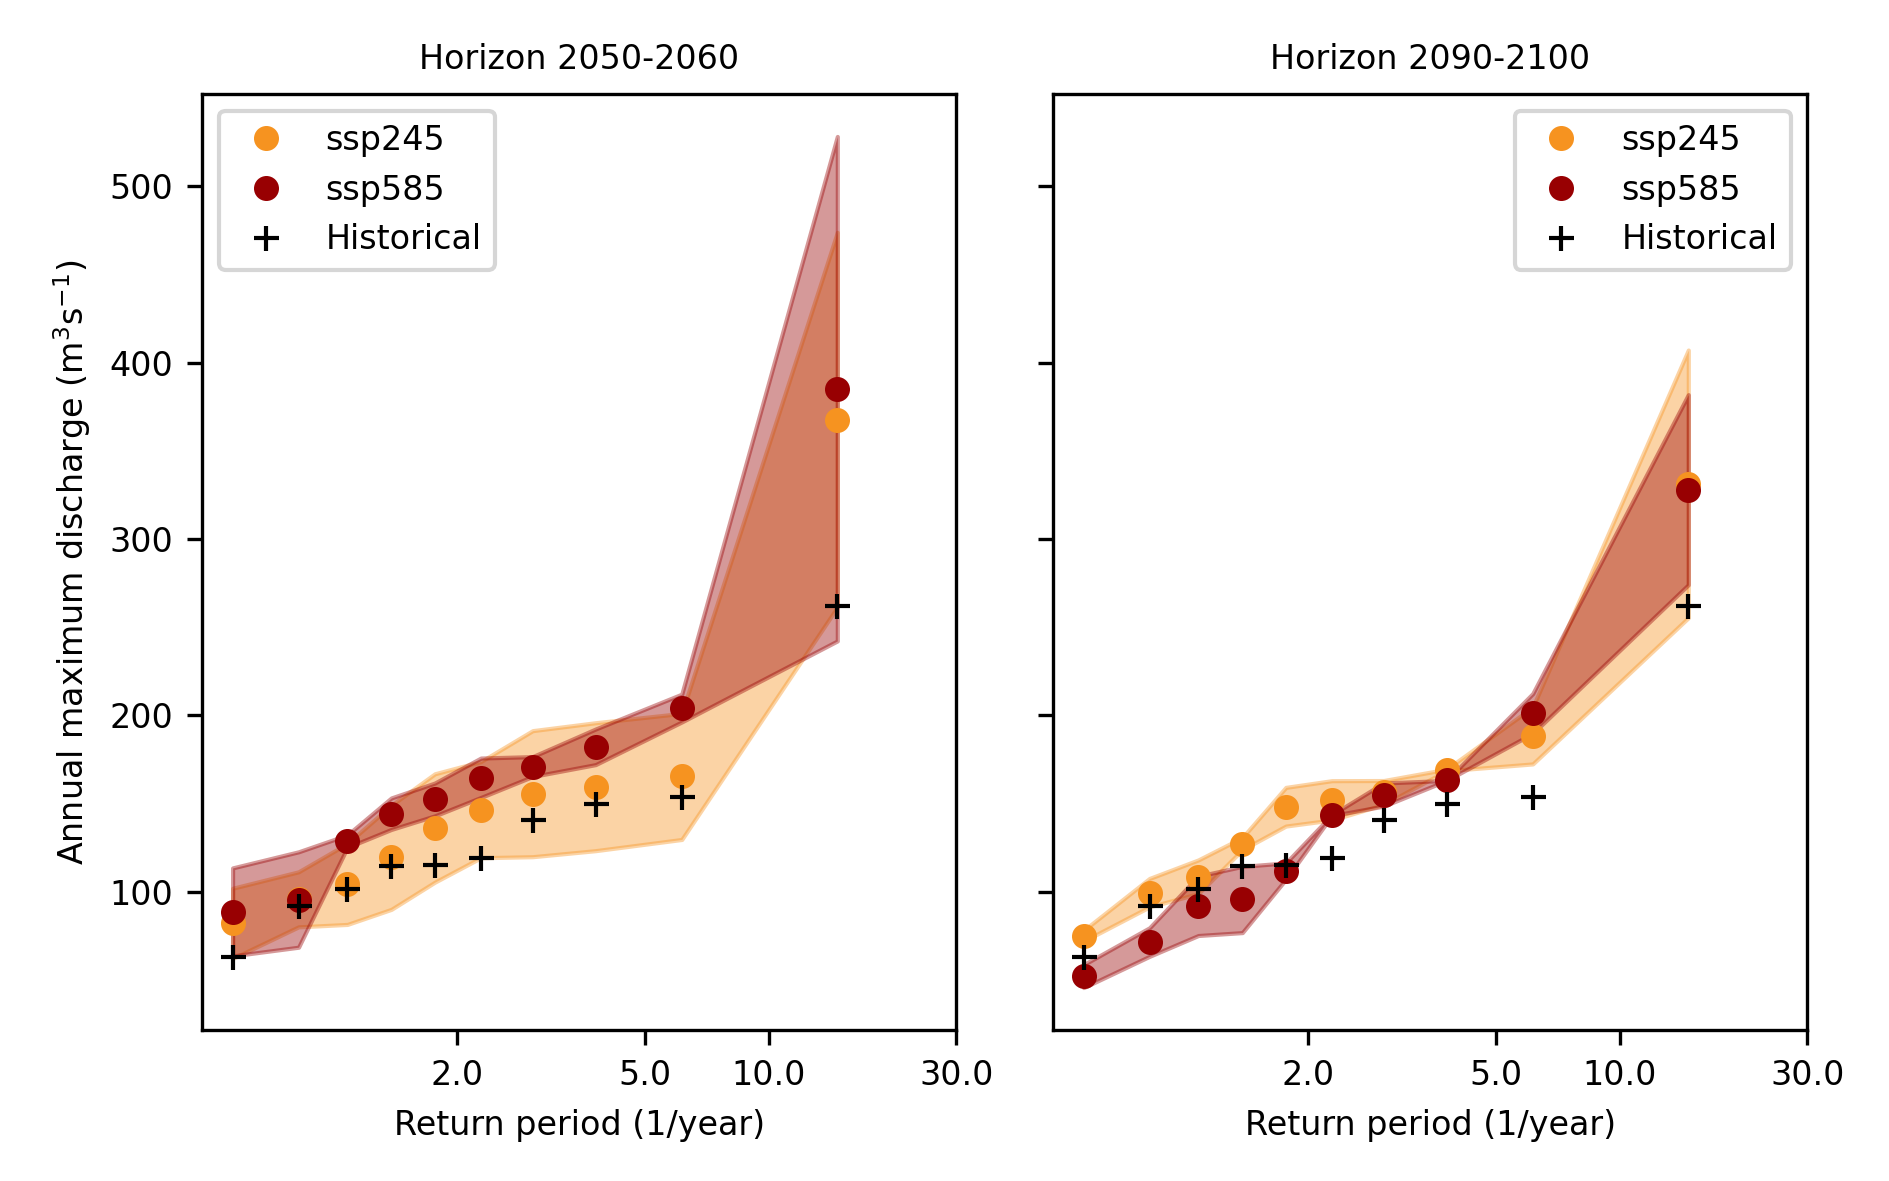

In [12]:
display.Image("./examples/myModel/plots/model_delta_runs/flow/1/plotting_pos_maxq_1.png")

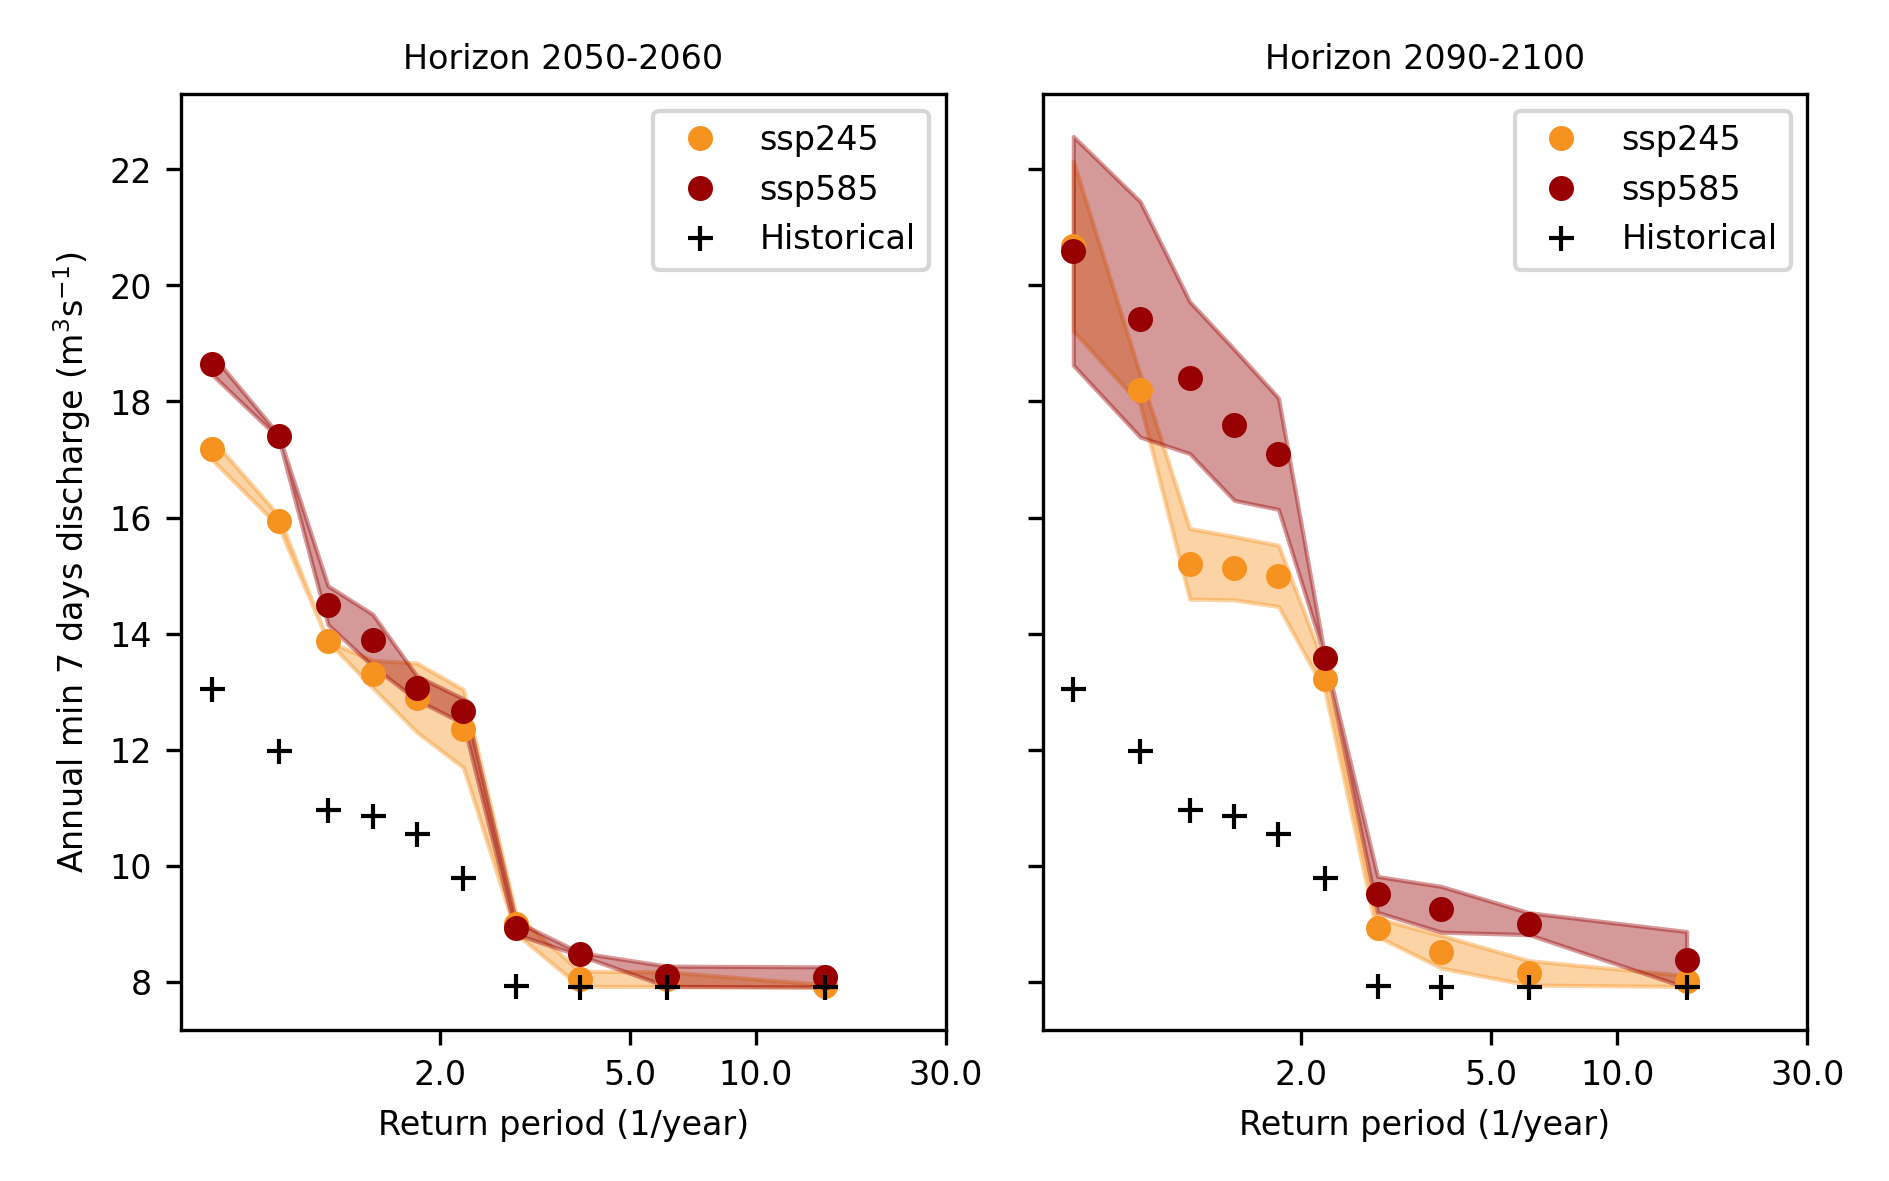

In [15]:
display.Image("./examples/myModel/plots/model_delta_runs/flow/1/plotting_pos_nm7q_1.png")

Boxplots showing the mean monthly discharge regime are also available as absolute values or relative change. 

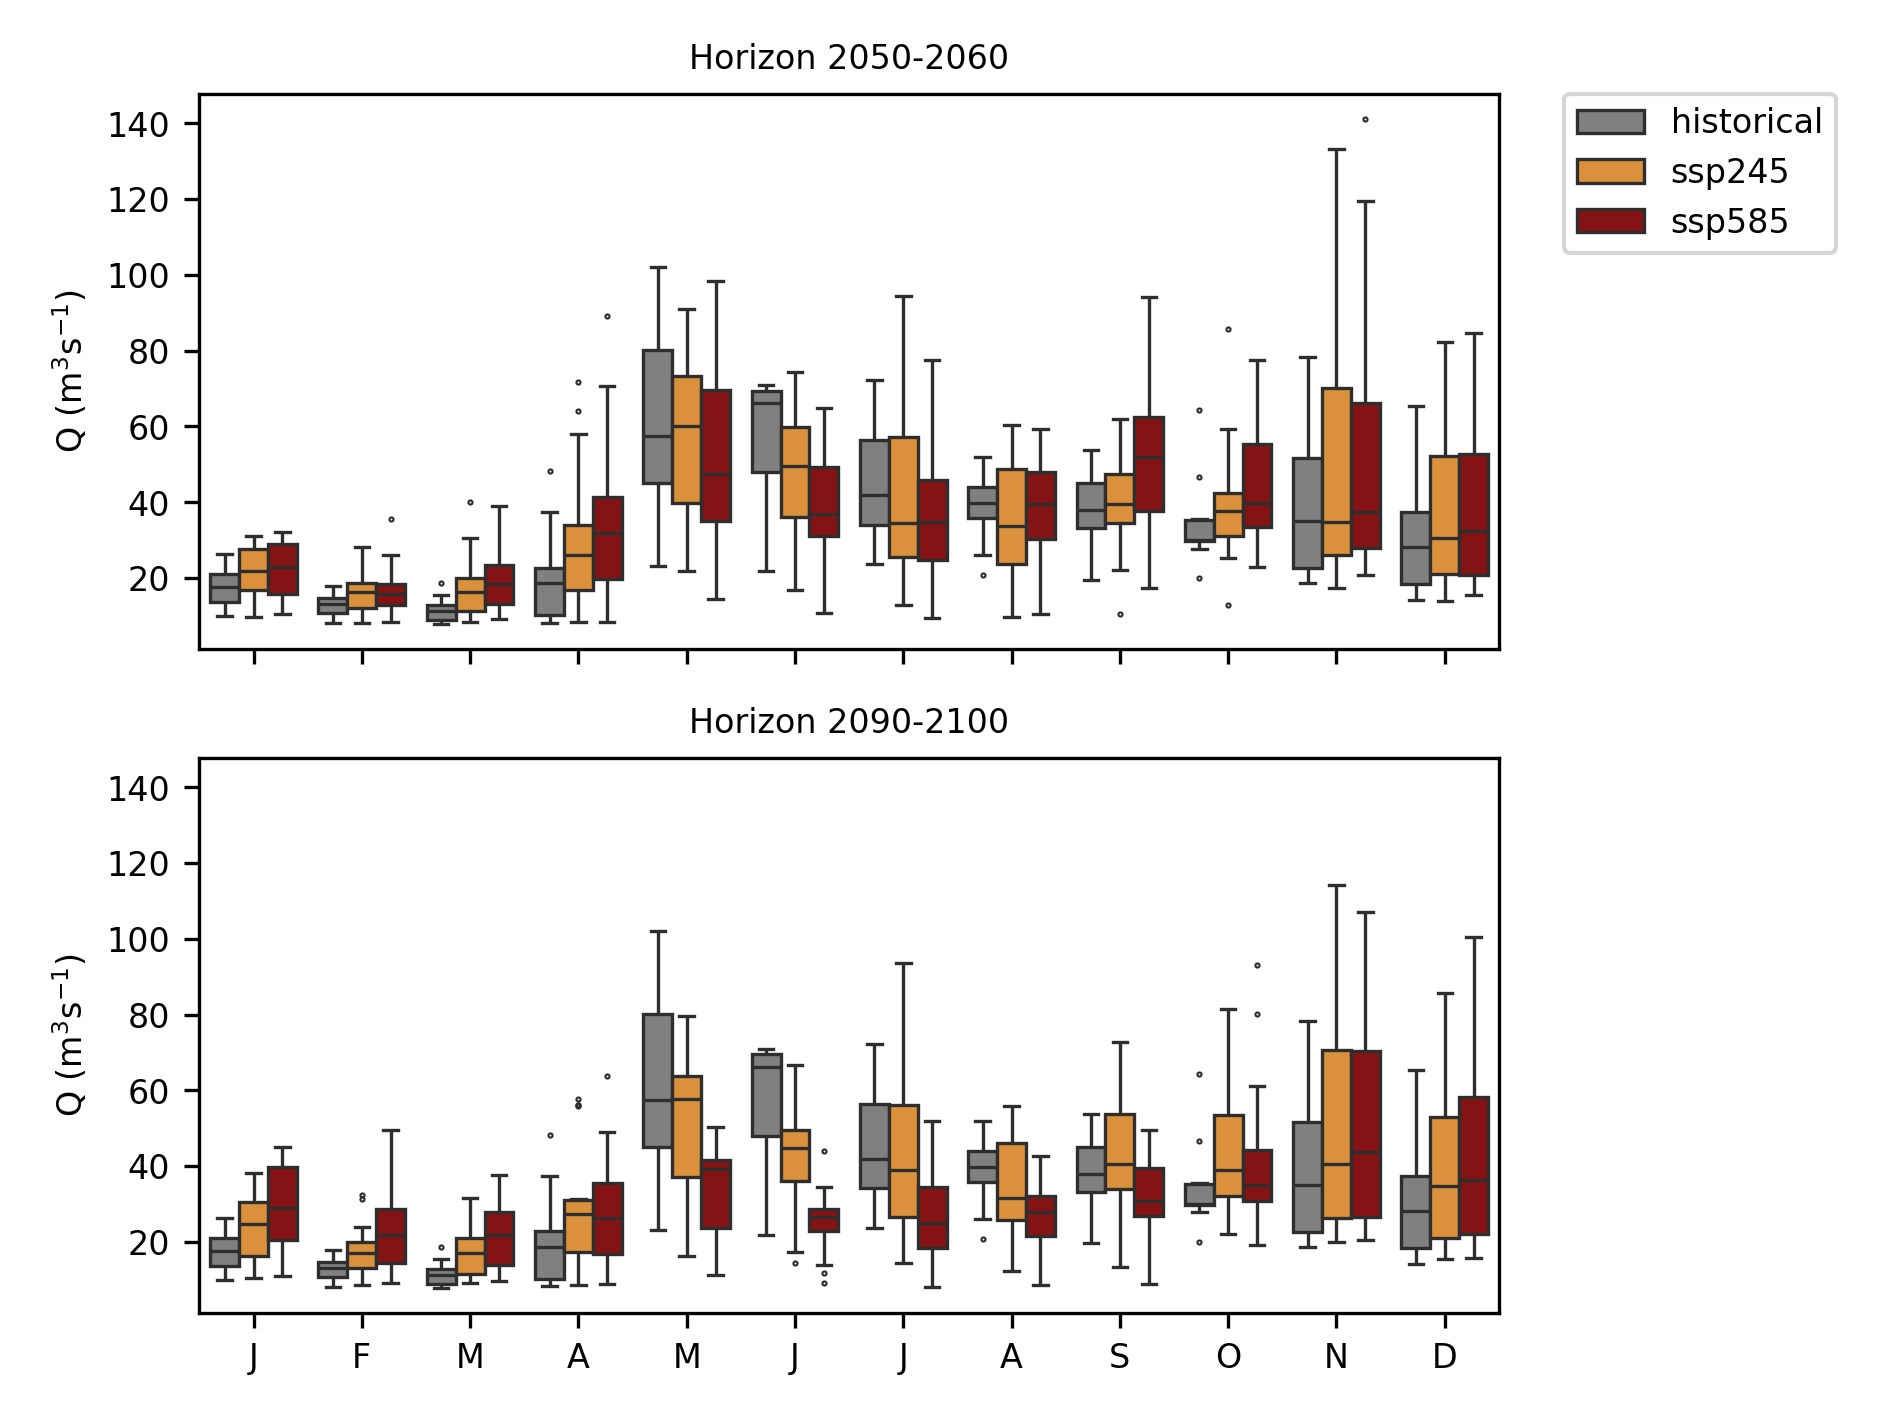

In [18]:
display.Image("./examples/myModel/plots/model_delta_runs/flow/1/boxplot_q_abs_1.png")

Besides streamflow, we also evaluate the change in other flux and state variables, including:
- actual evaporation
- groundwater recharge
- overland flow 
- snow water equivalent storage
- glacier water equivalent storage. 

The plots are available with:
- absolute values 
- relative change

The figures show:
- mean monthly regime,
- annual regime. 

Several of these figures are shown below as illustration:
- sum of annual actual evaporation 
- change of mean monthly groundwater recharge
- mean monthly snow water equivalent.

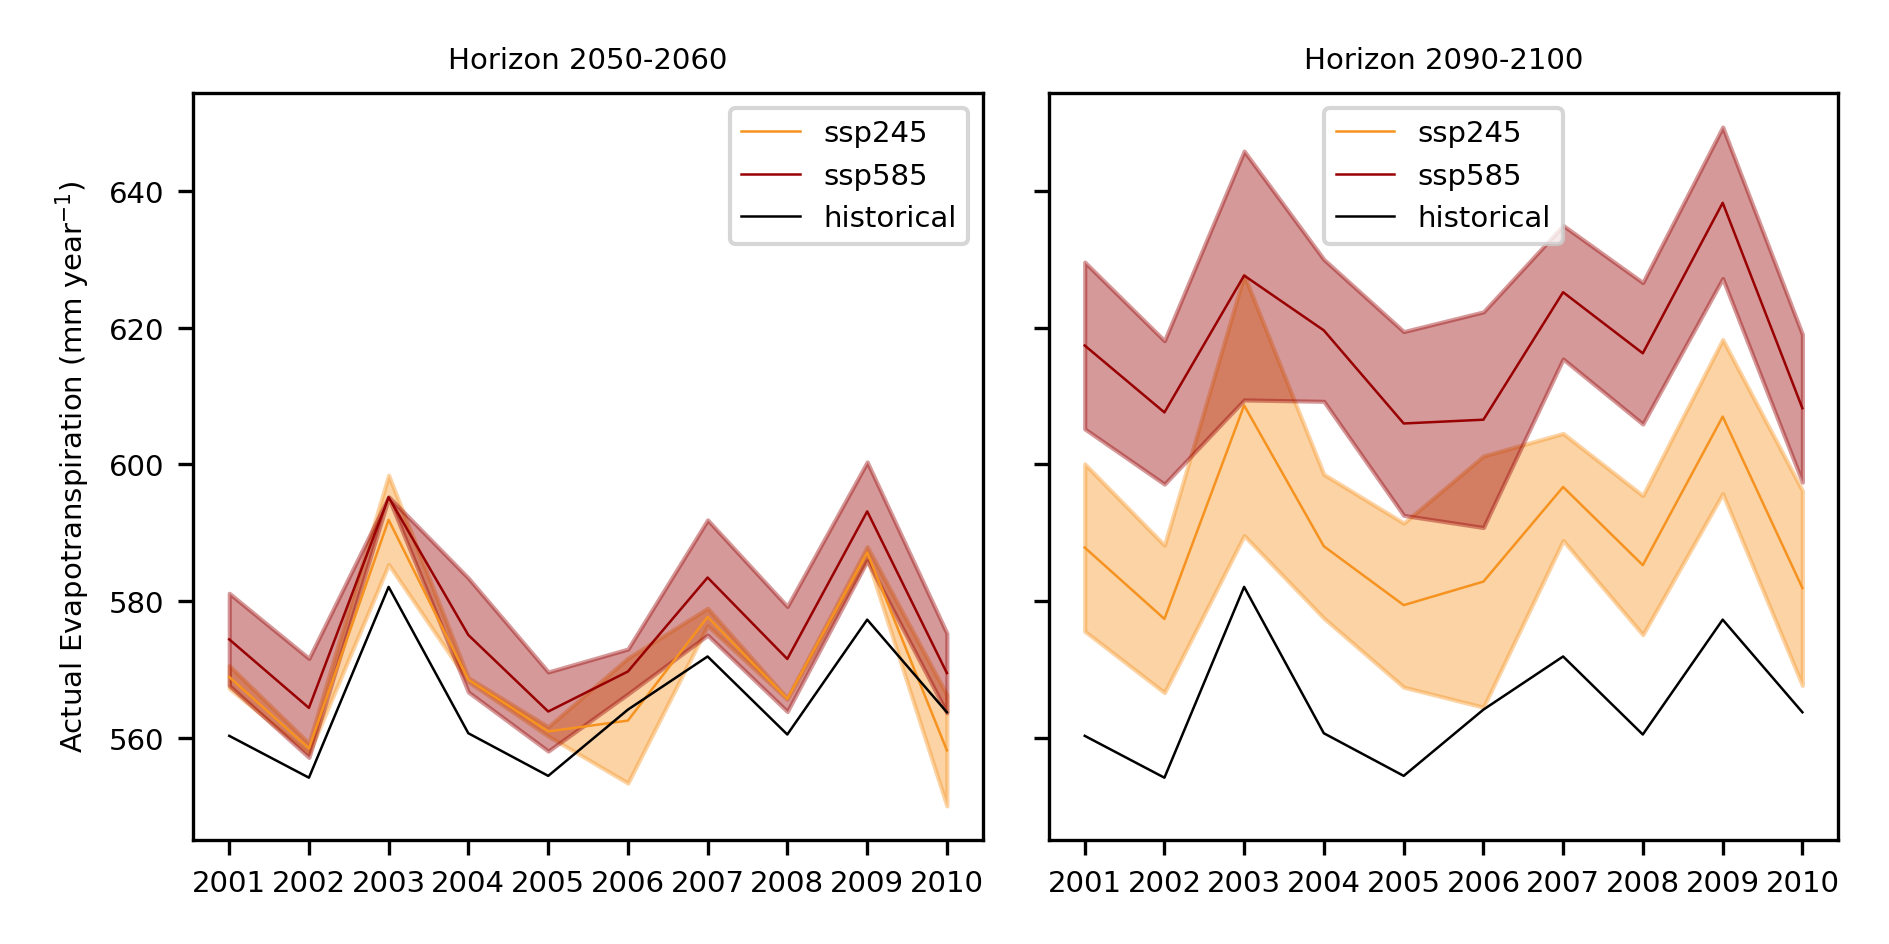

In [19]:
display.Image("./examples/myModel/plots/model_delta_runs/other/sum_annual_actual evaporation_basavg.png")

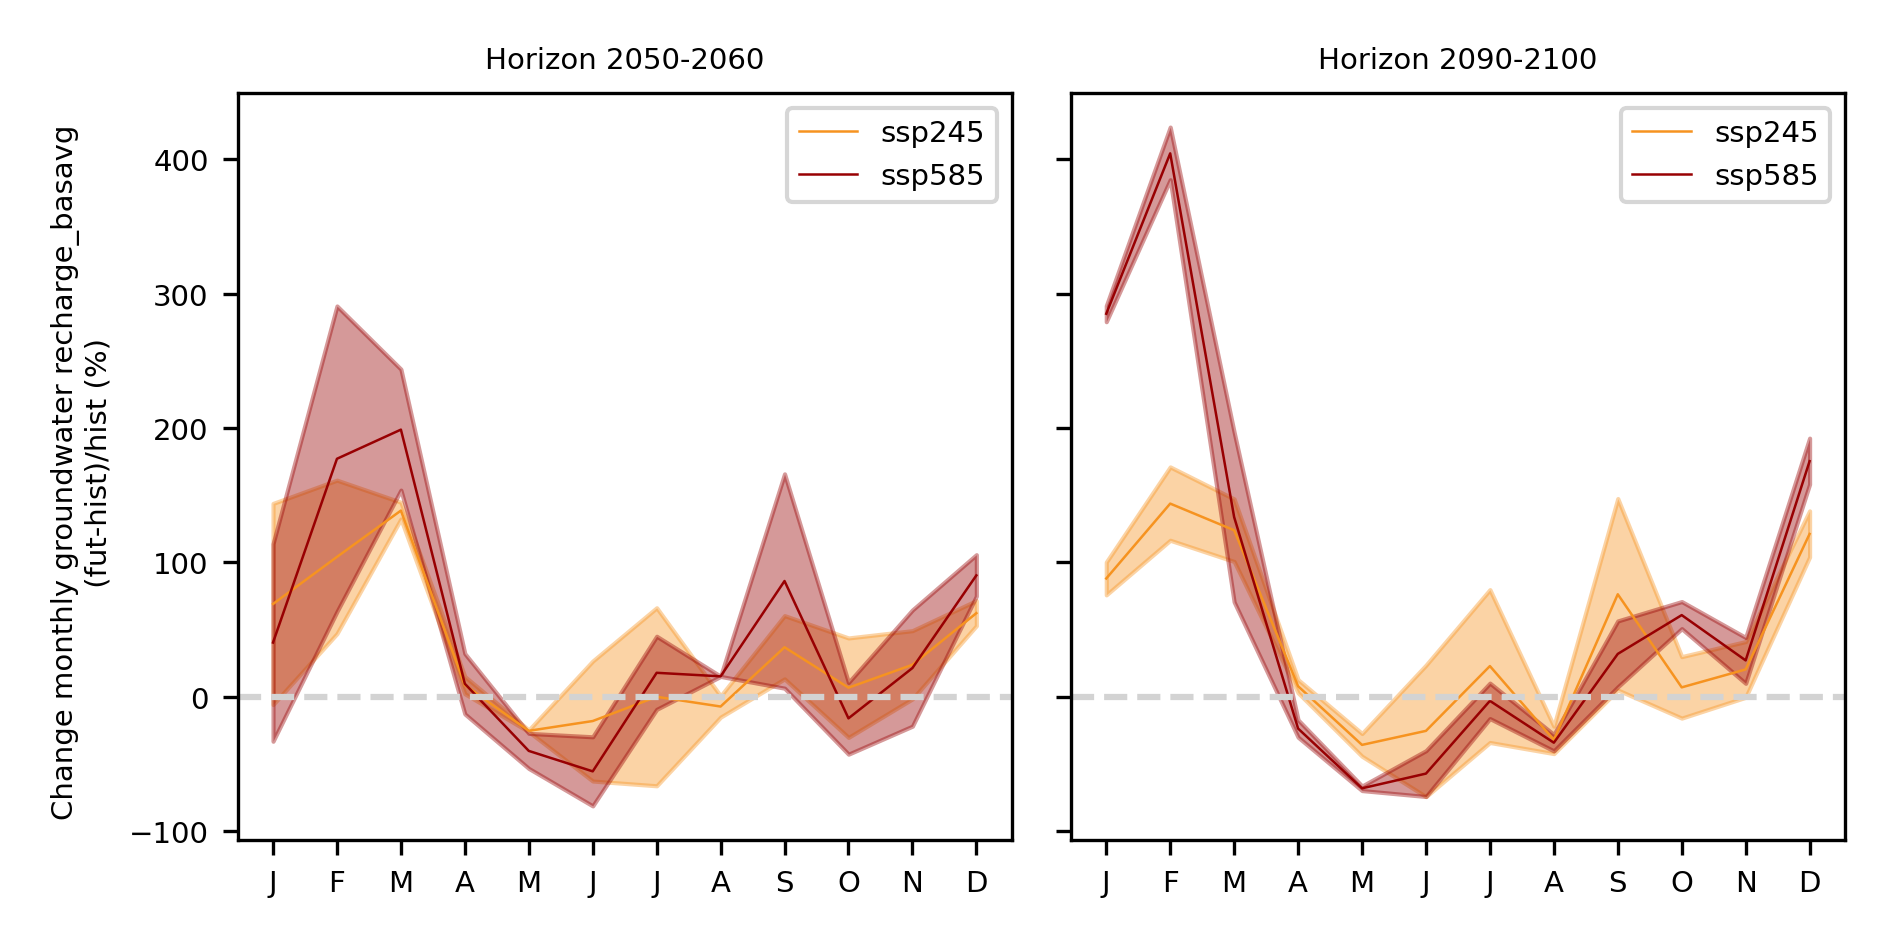

In [22]:
display.Image("./examples/myModel/plots/model_delta_runs/other/rel_mean_monthly_groundwater recharge_basavg.png")

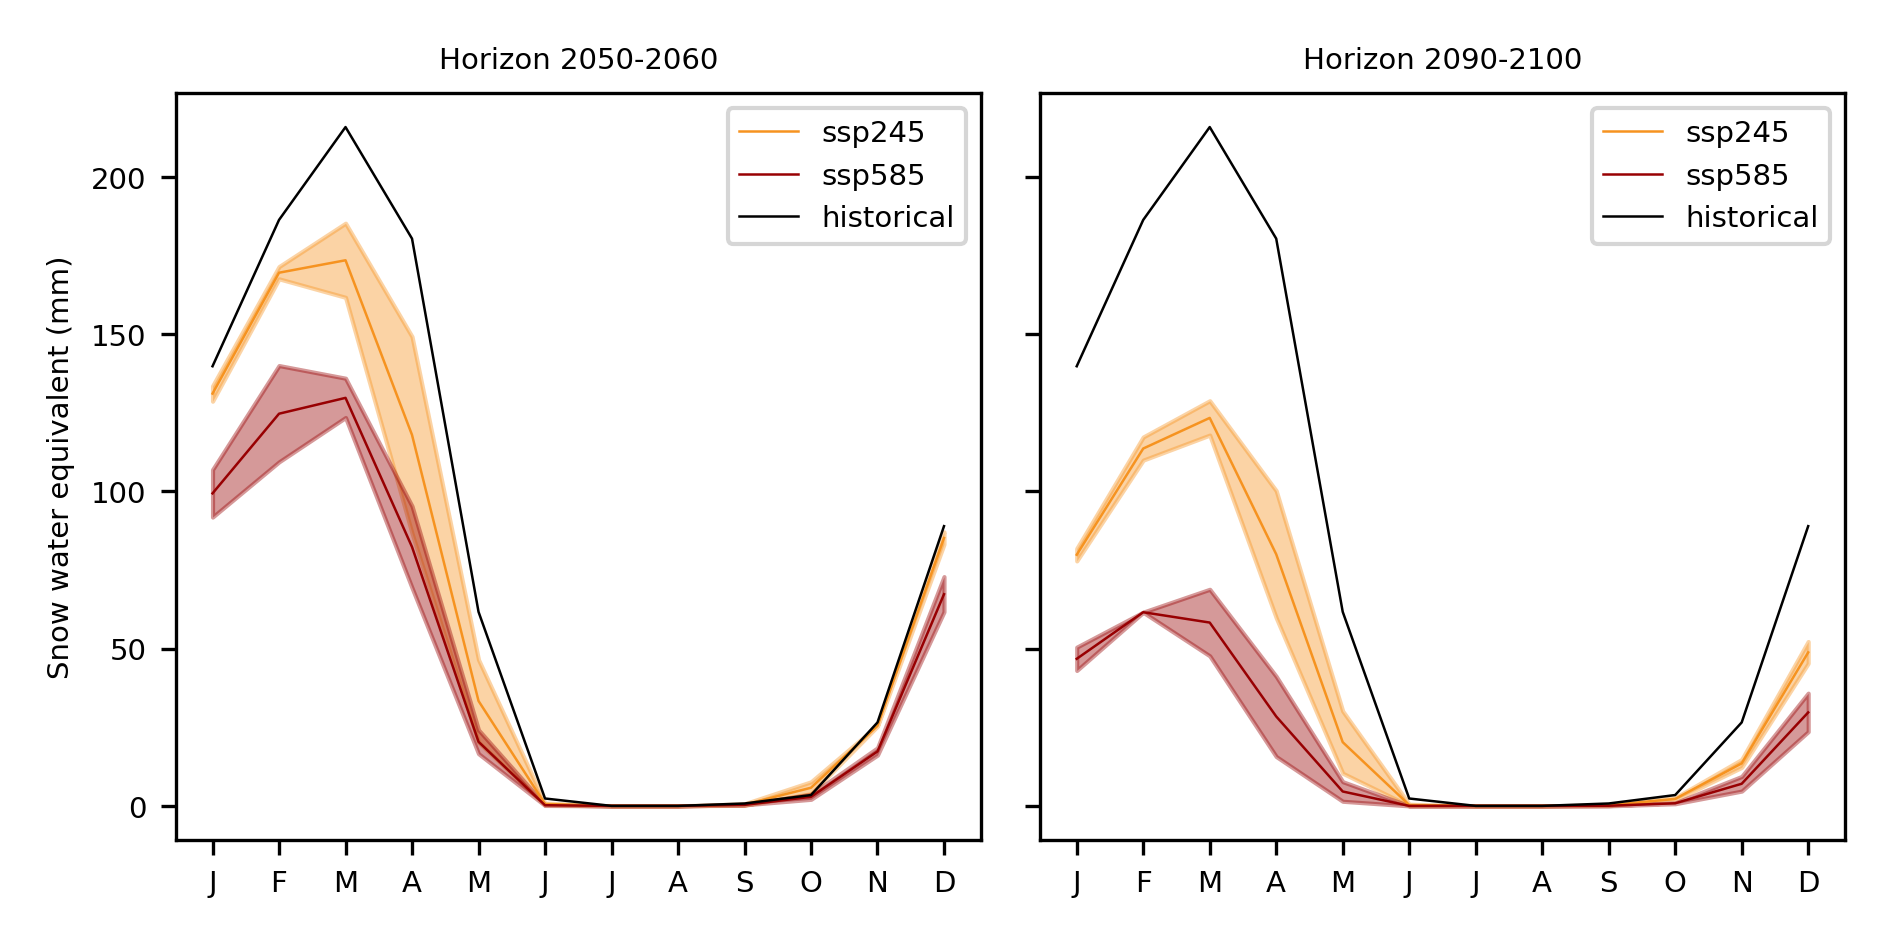

In [20]:
display.Image("./examples/myModel/plots/model_delta_runs/other/mean_monthly_snow_basavg.png")

In the above figures, we see:
- a substantial increase in actual evaporation for the far future for both scenarios
- an increase in groundwater recharge in the period January-March for the near and more strongly the far future
- a substantial decrease in snow storage for the far future for both scenarios

The workflow also shows changes in gridded snow water equivalent between the historical period and the future scenario, an example is shown below. 

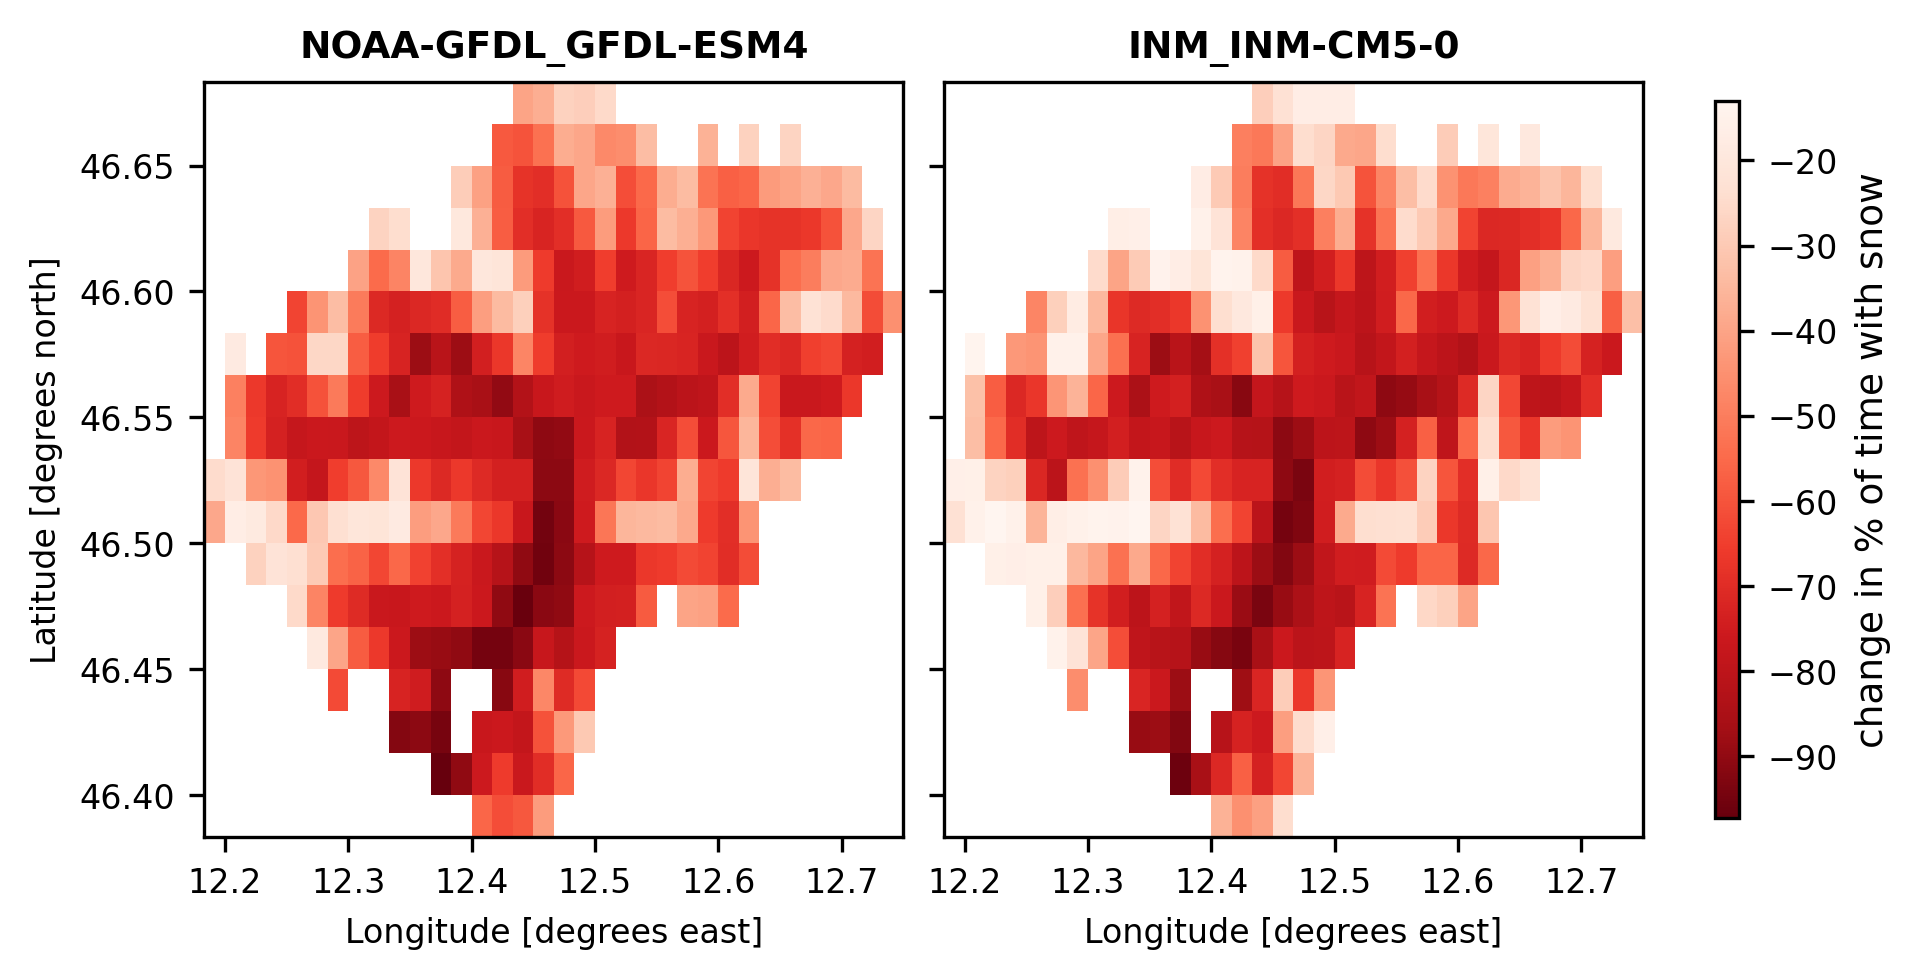

In [23]:
display.Image("./examples/myModel/plots/model_delta_runs/other/snow_cover_ssp585_far_rel.png")

In summary, the ensemble of plots generated in the hydrological projections workflow allows the user to gain a comprehensive overview of projected change in streamflow and other state and flux variables. 